In [1]:
!pip install transformers
import pandas as pd 
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('quotes.csv')

In [3]:
data["name"].unique()

array(['Пушкин', 'Есенин', 'Пастернак', 'Маяковский', 'Высоцкий',
       'Достоевский', 'Лермонтов', 'Шекспир', 'Булгаков', 'Бродский',
       'Горький', 'Хаям', 'Кафка', 'Тургенев'], dtype=object)

In [4]:
data = data[(data["name"] == "Кафка") | (data["name"] == "Пушкин")]
data["auth_id"][data['name'] == "Кафка"] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [5]:
rez = np.zeros((len(data), 2), dtype=np.float64)
k = 0
for i in data["auth_id"]:
  rez[k][int(i)] = 1
  k = k + 1

In [6]:
import sklearn

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data["quote"], rez, test_size=0.1)

In [7]:
# pip install transformers sentencepiece
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
train_tokens = tokenizer.batch_encode_plus(list(X_train),max_length=256,padding='longest',truncation=True, return_tensors = "pt")

In [8]:
from torch.utils.data import TensorDataset
train_ds = TensorDataset(train_tokens["input_ids"], torch.tensor(y_train, dtype=torch.float), train_tokens["attention_mask"])

In [9]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=20, shuffle=False)

In [10]:
from torch import nn
class CustomBERTModel(nn.Module):
    def __init__(self):
          super(CustomBERTModel, self).__init__()
          self.bert = BertModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
          ### New layers:
          self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True, num_layers = 4, dropout = 0.3)
          self.linear = torch.nn.Sequential(
              nn.Linear(256*2, 256),
              torch.nn.Tanh(),
              nn.Dropout(0.2),
              nn.Linear(256, 128),
              torch.nn.Tanh(),    
              nn.Linear(128, 64),
              torch.nn.Tanh(),    
              nn.Linear(64, 32),
              torch.nn.Tanh(),    
              nn.Linear(32, 2)
          )
          self.softmax = nn.Softmax(dim = 1)
          self.bn = nn.BatchNorm1d(768)

    def forward(self, ids, mask):
          bert_output = self.bert(ids, attention_mask=mask)
          # sequence_output has the following shape: (batch_size, sequence_length, 768)
          batch_output = self.bn(bert_output["pooler_output"])
          lstm_output, (h,c) = self.lstm(torch.reshape(batch_output, (bert_output["pooler_output"].shape[0], 1, 768))) ## extract the 1st token's embeddings
          hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
          linear_output = self.linear(hidden.view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification
          #print(lstm_output[:3][-1][:512].shape)
          #linear_output = self.linear(lstm_output[:3][-1][:512])
          output = self.softmax(linear_output)
          return output

In [11]:
bert = CustomBERTModel()

In [12]:
optimizer = torch.optim.AdamW(bert.parameters(), lr = 2e-5)
criterion = torch.nn.CrossEntropyLoss()

In [13]:
from IPython.display import clear_output

In [14]:
test_tokens = tokenizer.batch_encode_plus(list(X_test),max_length=256,padding='longest',truncation=True, return_tensors = "pt")
from torch.utils.data import TensorDataset
test_ds = TensorDataset(test_tokens["input_ids"], torch.tensor(y_test, dtype=torch.float), test_tokens["attention_mask"])
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=20, shuffle=False)

Train loss: 


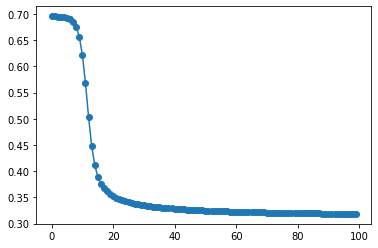

Test loss: 


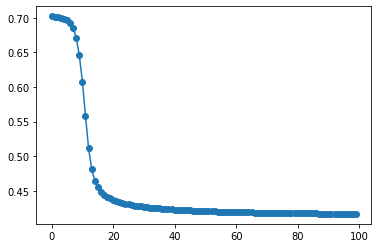

epoch: 99


In [15]:
import matplotlib.pyplot as plt

test_loss_avgs = []
train_loss_avgs = []
samples_list = []
i = 0
device = torch.device("cuda")

bert.to(device)
criterion.to(device)

loss_avgs = []

bert.train()
for epoch in range(100):
    bert.train()
    loss_list = list()
    for batch in train_dl:
        i = i + 1
        optimizer.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[2].to(device)
        outputs = bert(input_ids, attention_mask)
        loss = criterion(outputs, batch[1].to(device))
        loss_list.append(float(loss))

        loss.backward()
        optimizer.step()

    train_loss_avgs.append(sum(loss_list) / len(loss_list))

    clear_output()
    print("Train loss: ")
    plt.plot(train_loss_avgs, '-o')
    plt.show()

    loss_list = list()

    bert.eval()
    with torch.no_grad():
      for batch in test_dl:
        input_ids = batch[0].to(device)
        attention_mask = batch[2].to(device)
        outputs = bert(input_ids, attention_mask)
        loss = criterion(outputs, batch[1].to(device))
        loss_list.append(float(loss))

    test_loss_avgs.append(sum(loss_list)/len(loss_list))

    print("Test loss: ")
    plt.plot(test_loss_avgs, '-o')
    plt.show()

    print(f'epoch: {epoch}')
